In [1]:
import os
import numpy as np
import pandas as pd
import glob
import random
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from torch.utils.data import DataLoader, TensorDataset
from server_utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from braindecode.models import EEGNetv4


# 参数设置
fs = 250
subject_id = 3  # 修改为当前受试者编号
base_data_path = f"/mnt/dataset0/xkp/closed-loop/data/sub{subject_id}"
eeg_folders = ["pre_eeg_1", "pre_eeg_2",]  # 要加载的所有预实验数据文件夹

# 存储所有实验数据
all_eeg_data = []
all_labels = []

# 从每个实验文件夹加载数据
for folder in eeg_folders:
    folder_path = os.path.join(base_data_path, folder)
    
    if not os.path.exists(folder_path):
        print(f"警告: 文件夹 {folder_path} 不存在，跳过")
        continue
    
    print(f"\n加载数据文件夹: {folder_path}")
    
    # 加载标签
    labels_path = os.path.join(folder_path, "labels.npy")
    if os.path.exists(labels_path):
        labels = np.load(labels_path)
        print(f"从 {folder} 加载了 {len(labels)} 个标签")
    else:
        print(f"警告: 在 {folder} 中没有找到labels.npy文件")
        continue
    
    # 加载EEG文件
    eeg_files = sorted([f for f in os.listdir(folder_path) 
                 if f.endswith('.npy') and f != 'labels.npy'])
    
    if len(eeg_files) != len(labels):
        print(f"警告: {folder} 中的EEG文件数量 ({len(eeg_files)}) 与标签数量 ({len(labels)}) 不匹配")
        continue
    
    # 加载EEG数据
    eeg_file_paths = [os.path.join(folder_path, f) for f in eeg_files]
    eeg_data = np.array([np.load(file) for file in eeg_file_paths])
    
    print(f"从 {folder} 加载了 {len(eeg_data)} 个EEG样本，形状为 {eeg_data.shape}")
    
    # 将数据添加到总集合中
    all_eeg_data.append(eeg_data)
    all_labels.extend(labels)

# 合并所有数据
if all_eeg_data:
    combined_eeg_data = np.concatenate(all_eeg_data, axis=0)
    combined_labels = np.array(all_labels)
    
    # 打乱数据
    indices = np.arange(len(combined_labels))
    np.random.shuffle(indices)
    combined_eeg_data = combined_eeg_data[indices]
    combined_labels = combined_labels[indices]
    
    print(f"\n成功合并数据 - 共 {len(combined_eeg_data)} 个样本，{len(combined_labels)} 个标签")
    print(f"合并后的EEG数据形状: {combined_eeg_data.shape}")
    print(f"标签分布: {np.unique(combined_labels, return_counts=True)}")
else:
    print("错误: 没有成功加载任何数据")


加载数据文件夹: /mnt/dataset0/xkp/closed-loop/data/sub3/pre_eeg_1
从 pre_eeg_1 加载了 150 个标签
从 pre_eeg_1 加载了 150 个EEG样本，形状为 (150, 64, 750)

加载数据文件夹: /mnt/dataset0/xkp/closed-loop/data/sub3/pre_eeg_2
从 pre_eeg_2 加载了 150 个标签
从 pre_eeg_2 加载了 150 个EEG样本，形状为 (150, 64, 750)

成功合并数据 - 共 300 个样本，300 个标签
合并后的EEG数据形状: (300, 64, 750)
标签分布: (array(['Amu', 'Dis'], dtype='<U3'), array([150, 150]))


In [2]:
# 转换标签
combined_labels = get_binary_labels(combined_labels)

print("转换后的标签", combined_labels)

# # 获取选定的通道
# selected_channel_idxes = get_selected_channel_idxes(combined_eeg_data, fs, 6)
# print("选择的通道索引:", selected_channel_idxes)

# # 提取特征并训练分类器
# features, valid_labels = extract_emotion_psd_features(combined_eeg_data, combined_labels, fs)
# print(f"提取的特征形状: {features.shape}")
# print(f"有效标签数量: {len(valid_labels)}")

# # 训练分类器和评估
# clf, report, y_test, y_pred = train_emotion_classifier(features, valid_labels, 0.2, 42)
# print("\n分类器报告:")
# print(report)

转换后的标签 [0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1
 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0
 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0
 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0
 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 1 1]


In [3]:
# # 使用pandas生成报告并绘制图表
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. 混淆矩阵可视化
# cm = confusion_matrix(y_test, y_pred)
# class_names = ['Dis', 'Amu']  # 根据你的标签类型调整
# cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix')
# plt.ylabel('Real Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.savefig(f'sub{subject_id}_confusion_matrix.png')
# plt.show()

# # 2. 性能指标条形图
# report_dict = classification_report(y_test, y_pred, output_dict=True)
# df_report = pd.DataFrame(report_dict).transpose()
# df_metrics = df_report.iloc[:-3]
# df_metrics = df_metrics.rename(index={'0': 'Dis', '1': 'Amu'})

# metrics = ['precision', 'recall', 'f1-score']
# df_plot = df_metrics[metrics]

# plt.figure(figsize=(10, 6))
# df_plot.plot(kind='bar', colormap='viridis')
# plt.title('Classification Report Metrics')
# plt.ylabel('Score')
# plt.xlabel('Class')
# plt.ylim(0, 1.0)
# plt.legend(title='Metrics', loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.savefig(f'sub{subject_id}_metrics_chart.png')
# print(f"图表已保存为sub{subject_id}_metrics_chart.png和sub{subject_id}_confusion_matrix.png")

# # 保存模型用于后续实验
# import pickle
# model_save_path = os.path.join(base_data_path, 'emotion_classifier.pkl')
# with open(model_save_path, 'wb') as f:
#     pickle.dump(clf, f)
# print(f"分类器模型已保存至 {model_save_path}")

### EEGNet E2E 实验



In [4]:
# 准备数据用于EEGNet
# 假设combined_eeg_data是(样本数, 通道数, 时间点)格式

# 转换为PyTorch张量
X = torch.tensor(combined_eeg_data, dtype=torch.float32)
y = torch.tensor(combined_labels, dtype=torch.long)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 创建数据加载器
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取数据形状信息
n_samples, n_channels, n_times = combined_eeg_data.shape
print(f"数据形状: {n_samples} 样本, {n_channels} 通道, {n_times} 时间点")

# 初始化EEGNetv4模型
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = EEGNetv4(
    n_channels,
    2,  # 二分类任务
    input_window_samples=n_times,
    final_conv_length='auto',
    pool_mode='mean',
    F1=8, 
    D=2, 
    F2=16,
    kernel_length=64,
    drop_prob=0.5  # 增加dropout可能有助于防止过拟合
)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

数据形状: 300 样本, 64 通道, 750 时间点
使用设备: cuda:1


/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# 训练函数
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 评估函数
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 统计
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_targets

# 训练模型
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, 
                device, num_epochs=50, early_stopping_patience=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    best_test_acc = 0.0
    best_model_wts = model.state_dict()
    no_improve_epochs = 0
    
    for epoch in range(num_epochs):
        # 训练阶段
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 评估阶段
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # 学习率调整
        scheduler.step(test_loss)
        
        # 打印训练信息
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        
        # 保存最佳模型
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_wts = model.state_dict().copy()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        
        # 早停
        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # 加载最佳模型
    model.load_state_dict(best_model_wts)
    
    return model, train_losses, test_losses, train_accs, test_accs

Epoch 1/100: Train Loss: 0.7613, Train Acc: 0.5333, Test Loss: 0.6847, Test Acc: 0.6000
Epoch 2/100: Train Loss: 0.7350, Train Acc: 0.5292, Test Loss: 0.6878, Test Acc: 0.6000
Epoch 3/100: Train Loss: 0.7639, Train Acc: 0.5250, Test Loss: 0.6896, Test Acc: 0.6000
Epoch 4/100: Train Loss: 0.7169, Train Acc: 0.6083, Test Loss: 0.6901, Test Acc: 0.5833
Epoch 5/100: Train Loss: 0.6902, Train Acc: 0.5875, Test Loss: 0.6908, Test Acc: 0.5833
Epoch 6/100: Train Loss: 0.6994, Train Acc: 0.5792, Test Loss: 0.6911, Test Acc: 0.5667
Epoch 7/100: Train Loss: 0.7212, Train Acc: 0.5708, Test Loss: 0.6911, Test Acc: 0.5667
Epoch 8/100: Train Loss: 0.6744, Train Acc: 0.6208, Test Loss: 0.6910, Test Acc: 0.5667
Epoch 9/100: Train Loss: 0.7073, Train Acc: 0.5792, Test Loss: 0.6911, Test Acc: 0.5667
Epoch 10/100: Train Loss: 0.6918, Train Acc: 0.5917, Test Loss: 0.6913, Test Acc: 0.6000
Epoch 11/100: Train Loss: 0.6979, Train Acc: 0.6333, Test Loss: 0.6913, Test Acc: 0.6000
Epoch 12/100: Train Loss: 0.63

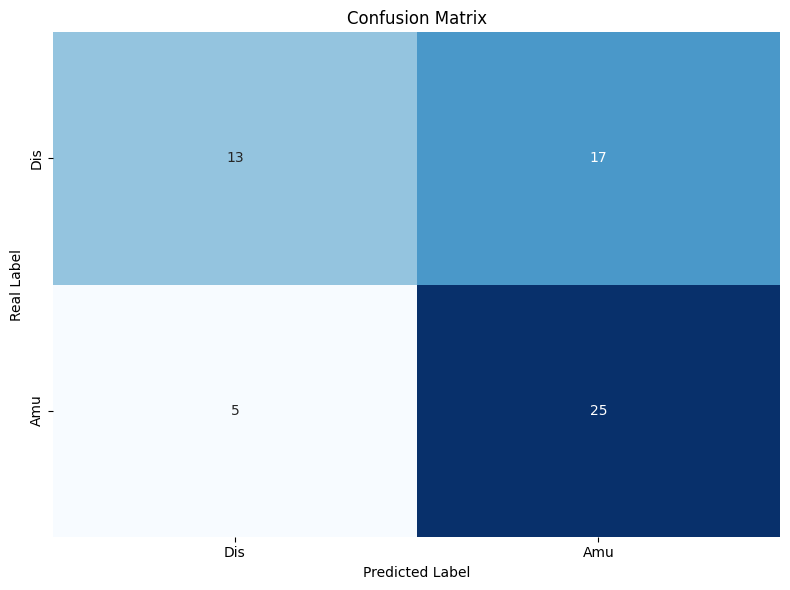

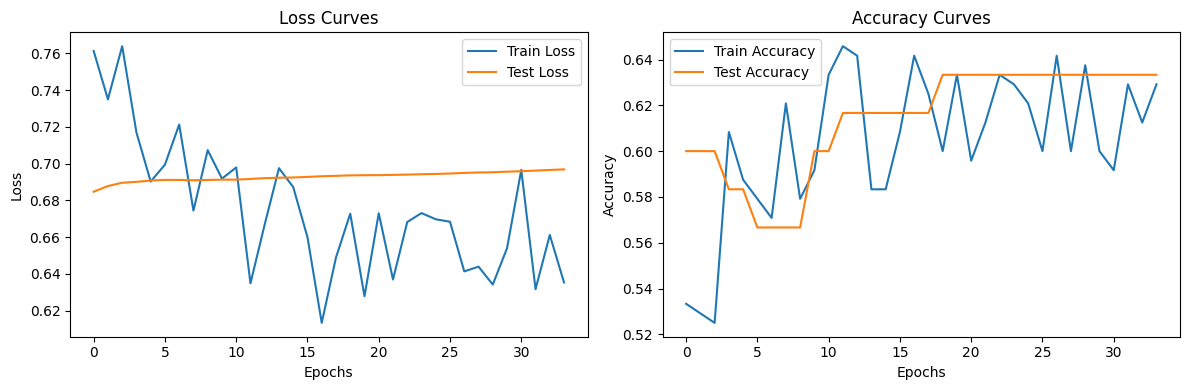

EEGNet模型已保存至 /mnt/dataset0/xkp/closed-loop/data/sub3/eegnet_emotion_model.pth
训练历史已保存至 /mnt/dataset0/xkp/closed-loop/data/sub3/eegnet_training_history.pkl


In [6]:
# 训练模型
num_epochs = 100  # 设置足够大的训练轮数，依赖早停机制
trained_model, train_losses, test_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device, 
    num_epochs=num_epochs, early_stopping_patience=15
)

# 在测试集上进行最终评估
_, test_acc, y_pred, y_true = evaluate(trained_model, test_loader, criterion, device)
print(f"测试集最终准确率: {test_acc:.4f}")

# 生成分类报告
print("\n分类报告:")
class_names = ['Dis', 'Amu']  # 负面和积极情绪
print(classification_report(y_true, y_pred, target_names=class_names))

# 混淆矩阵可视化
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Real Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'sub{subject_id}_eegnet_confusion_matrix.png')
plt.show()

# 训练过程可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.savefig(f'sub{subject_id}_eegnet_training_curves.png')
plt.show()

# 保存模型
model_save_path = os.path.join(base_data_path, 'eegnet_emotion_model.pth')
torch.save(trained_model.state_dict(), model_save_path)
print(f"EEGNet模型已保存至 {model_save_path}")

# 如果需要，可以保存完整的训练历史记录
history = {
    'train_loss': train_losses,
    'test_loss': test_losses,
    'train_acc': train_accs,
    'test_acc': test_accs
}
history_save_path = os.path.join(base_data_path, 'eegnet_training_history.pkl')
with open(history_save_path, 'wb') as f:
    pickle.dump(history, f)
print(f"训练历史已保存至 {history_save_path}")